In [1]:
import sys
import numpy as np
from collections import defaultdict

from utils import plot_blackjack_values, plot_policy
from blackjack import BlackjackEnv

In [2]:
# init the environment
env = BlackjackEnv()

In [3]:
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)


## Play with a Random Policy

In [4]:
for i_episode in range(3):

    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward:', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(19, 10, True)
End game! Reward: 1.0
You won :)

(10, 2, False)
(15, 2, False)
(17, 2, False)
End game! Reward: 0.0
You lost :(

(8, 1, False)
(15, 1, False)
End game! Reward: -1
You lost :(



## Part 1: MC Prediction

In [5]:
def generate_episode_from_limit_stochastic(env):
    
    episode = []
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] # state index 0 is for player
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [6]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # init empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        
        # obtain the states, actions and rewards
        states, actions, rewards = zip(*episode)
        
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # update the sum of the returns, number of visits, and action-value
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [7]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

In [8]:
# obtain the corresponding state-value function
V_to_plot = dict((k, (k[0]>18) * (np.dot([0.8, 0.2], v)) + (k[0]<=18) * (np.dot([0.2, 0.8], v))) \
                  for k, v in Q.items())

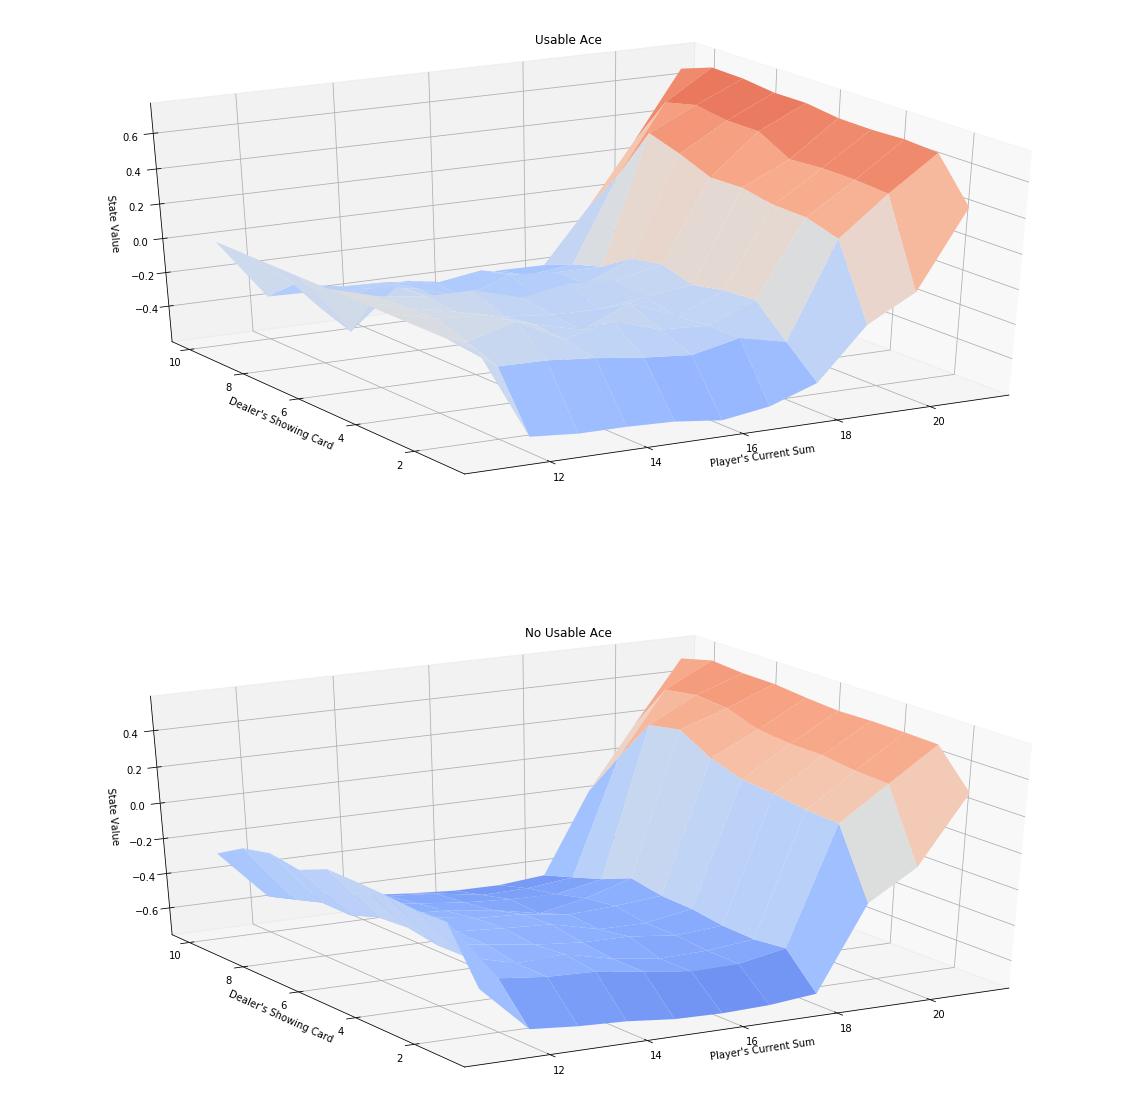

In [9]:
# plot the state-value function
plot_blackjack_values(V_to_plot)

## Part 2: MC Control

---